<a href="https://colab.research.google.com/github/cardstdani/covid-classification-ml/blob/main/ModelNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


##**Data gathering and preprocessing**

In [4]:
DIR = r"D:\Engage\Datasets\XRay_Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 30144 files belonging to 5 classes.
Using 27130 files for training.
Found 30144 files belonging to 5 classes.
Using 3014 files for validation.
['A', 'C', 'G', 'M', 'N']


##<b>Data augmentation</b>

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

##<b>Model Training</b>

In [ ]:
baseModel = tf.keras.applications.MobileNetV3Small(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.5) (last_output)
x = tf.keras.layers.GlobalMaxPooling2D() (last_output)
x = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), activity_regularizer=tf.keras.regularizers.l2(0.02),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
epochs = 30
timeDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 1 / (1 + 10 * epoch))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[stepDecay])

<b>Model Architecture and Management</b>

In [11]:
model.summary()
model.save('XRayClassificationModel.h5')

##<b>Evaluation</b>

**One Image Prediction**

[47.512  0.004  0.016  0.019 52.449] 
 ['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Prediction:  Viral Pneumonia 52.44930982589722%


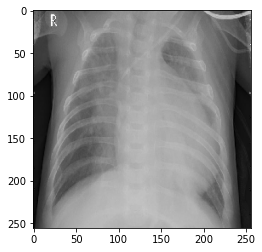

In [29]:
import requests

img_data = requests.get("https://cdn0.scrvt.com/0e46935d037de4ec3888566275864b37/1800000007267893/5a55409c371b/v/f8eac2053bc7/x-ray-COVID-19-2_1800000007267893.jpg?nowebp=1").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "img.jpg"
path = "D:\COVID_19\covid-classification-ml\Covid19_Dataset\Viral Pneumonia\person1_virus_11.jpeg"
#path = "/content/Covid19_Dataset/Normal/Normal-1000.png"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")